## GRACE processing script 

### This script processes GRACE data for the UCRB from three sources (JPL, CSR, GSFC). The data are area-weighted based on their relationship with the UCRB shapefile. Uncertainty is calculated by taking the standard deviation of the three products. 

### The final dataframe has been exported as GRACE_UCRB_AreaWeighted_DF.csv to the ExperimentRuns/pumping/Total directory and has replaced the former GRACE data in PF processing scripts. 

### At the end of this script, there is a comparison between this newly-processed GRACE data, the GRACE data processed by the cell-center method in ProcessingGRACE_2024, and the GRACE data that I processed in 2022. 

### Import usefule Libraries

In [10]:
!pip show exactextract
#!pip install exactextract

#!export PYTHONPATH=$PYTHONPATH:/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import rasterio as rst
from pyproj import Proj, transform, CRS
import geopandas as gpd
import netCDF4 as nc

import exactextract
from exactextract import exact_extract
import xagg as xa
!pwd

Name: exactextract
Version: 0.2.2
Summary: Fast and accurate raster zonal statistics
Home-page: 
Author: Daniel Baston
Author-email: 
License: 
                              Apache License
                        Version 2.0, January 2004
                     http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1. Definitions.

   "License" shall mean the terms and conditions for use, reproduction,
   and distribution as defined by Sections 1 through 9 of this document.

   "Licensor" shall mean the copyright owner or entity authorized by
   the copyright owner that is granting the License.

   "Legal Entity" shall mean the union of the acting entity and all
   other entities that control, are controlled by, or are under common
   control with that entity. For the purposes of this definition,
   "control" means (i) the power, direct or indirect, to cause the
   direction or management of such entity, whether by contract or
   otherwise, or (ii)

### Important Info/Links

https://isciences.github.io/exactextract/operations.html 

https://storymaps.arcgis.com/stories/5309a3a8eabd41478e5a47263a07e2f1

CSR Data: https://www2.csr.utexas.edu/grace/RL06.html

JPL Data: https://grace.jpl.nasa.gov/data/get-data/jpl_global_mascons/

GSFC Data: https://earth.gsfc.nasa.gov/geo/data/grace-mascons (GSFC.glb.200204_202406_RL06v2.0_OBP-ICE6GD_HALFDEGREE.nc) 

" HHU-IPM GRACE records for monthly TWSA values are in mm of equivalent water height for the reference period April 2002 to May 2022 in the form of a NetCDF file. They are anomalies regarding the period from January 2004 to December 2009. The data sets are provided at a spatial partitioning of 0.25-by-0.25 arc-degrees on the ellipsoid associated with the World Geodetic System 1984 (WGS84). The resolution is still GRACE’s native resolution which is 300–400 km, mainly due to the GRACE’s orbital configurations."

https://www.nature.com/articles/s41597-023-02122-1

### Read the India Shapefile:


<Figure size 1000x1000 with 0 Axes>

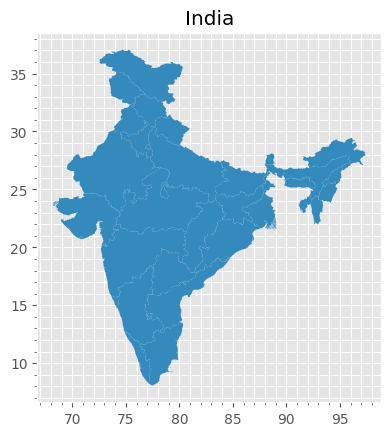

<Figure size 640x480 with 0 Axes>

In [11]:
basin_shapefile = gpd.read_file("/home/ms6985/ProcessingGRACE/Grazing_GRACE/india_wo_islands/india.shp")

# Plot of entire Colorado River Basin
plt.style.use('ggplot')
plt.figure(figsize=[10,10])
basin_shapefile.plot()
plt.title("India")
plt.grid(which="minor")
plt.minorticks_on()
plt.show()

#basin_shapefile.columns
basin_shapefile.head()

#print(basin_shapefile(column='name'))
#print(basin_shapefile[column='Haryana'].drop_duplicates())

plt.savefig(f"all_india_wo_islands.png", dpi=300, bbox_inches='tight')

### Read the GRACE Data  (JPL, CSR, GSFC) 

In [12]:
# JPL:
jpl = 'GRCTellus.JPL.200204_202503.GLO.RL06.3M.MSCNv04CRI.nc'
grace_jpl = xr.open_dataset(jpl)

# # CSR: 
# csr = 'water:geospatial/CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc'
# grace_csr = xr.open_dataset(csr)

# # GSFC
# gsfc = 'water:geospatial/gsfc.glb_.200204_202406_rl06v2.0_obp-ice6gd_halfdegree.nc'

# grace_gsfc = xr.open_dataset(gsfc)


#### using **xagg**

https://xagg.readthedocs.io/en/latest/notebooks/base_run.html

https://xagg.readthedocs.io/en/latest/xagg.html#xagg.core.aggregate

https://xagg.readthedocs.io/en/latest/xagg.html#xagg.wrappers.pixel_overlaps:~:text=%5Bsource%5D-,%EF%83%81,-Wrapper%20function%20for

In [13]:

# Calculate overlaps
ds_jpl = grace_jpl

gdf= basin_shapefile#one_state#

# Area Weighted Avg Weight File
weightmap_jpl = xa.pixel_overlaps(ds_jpl,gdf)

# Aggregated to Shapefile
aggregated_jpl = xa.aggregate(ds_jpl,weightmap_jpl)

# Example as an xarray dataset
ds_out_jpl = aggregated_jpl.to_dataset()


creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
adjusting grid... (this may happen because only a subset of pixels were used for aggregation for efficiency - i.e. [subset_bbox=True] in xa.pixel_overlaps())
grid adjustment successful
aggregating lwe_thickness...
aggregating uncertainty...
aggregating lat_bounds...
aggregating lon_bounds...
aggregating land_mask...
aggregating scale_factor...
aggregating mascon_ID...
aggregating GAD...
all variables aggregated to polygons!


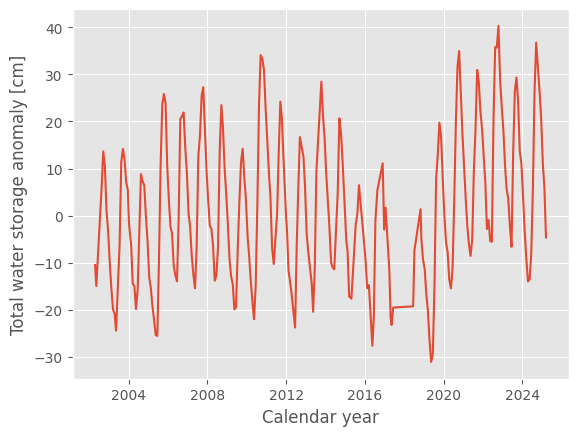

In [14]:
plt.figure()
plt.plot(ds_out_jpl.time,ds_out_jpl['lwe_thickness'][0,:])
plt.xlabel('Calendar year')
plt.ylabel('Total water storage anomaly [cm]')
# Save as PDF
plt.savefig(f"all_india_wo_islands.pdf", dpi=300, bbox_inches='tight')
plt.savefig(f"all_india_wo_islands.png", dpi=300, bbox_inches='tight')

In [15]:
"""
creating a dataframe of nans with dates; will merge other dataframes to this one, and if they have a missing date then the 
value of the merged dataframe will remain NaN
"""

start_date = '2002-04'
end_date = '2025-03'
start_date
# Create a datetime array with a monthly frequency
missing_datetime_array = pd.date_range(start=start_date, end=end_date, freq='ME').to_period('M')  # 'M' for monthly

missing_data_df = pd.DataFrame()
missing_data_df["anomaly_cm"] = np.zeros(275) * np.nan
missing_data_df.set_index(missing_datetime_array, inplace=True)


"""
creating dataframes for each of the products (jpl, csr, gsfc)
"""
jpl_df_lwe = ds_out_jpl['lwe_thickness'][0,:]
jpl_df_time = ds_out_jpl['time']
jpl_DF_raw = pd.DataFrame(data = {'JPL_cm':jpl_df_lwe}, index = jpl_df_time)
jpl_DF_raw.index = jpl_DF_raw.index.strftime('%Y-%m')
jpl_DF_raw.index = pd.to_datetime(jpl_DF_raw.index).to_period('M')

#csr_df_lwe = ds_out_csr['lwe_thickness'][0,:]
og_date = datetime.datetime(2002,1,1,0,0,0) # original date 
pd.to_datetime(og_date,format='%Y/%m')


"""
merging each dataframe with the missing data dataframe (missing_data_df) 
"""
jpl_df_merged = jpl_DF_raw.merge(right = missing_data_df, how = 'right', left_index = True, right_index = True)
jpl_df_merged.drop('anomaly_cm', axis = 1, inplace=True)

"""
for duplicate dates, applying a nanmean operation to take the mean of the two date values. 
then, making sure that all values in the aggredated dataframes are float values. 

**each DF has 1-2 duplicate dates. 
"""
jpl_df_aggregated = jpl_df_merged.groupby(jpl_df_merged.index).apply(lambda x: np.nanmean(x, axis=0))
jpl_df_aggregated = jpl_df_aggregated.astype(float)
"""
now, merging all the dataframes into one final dataframe. Will calculate the avg and STD on this one and then save it. 
"""
GRACE_AreaWeighted_DF = pd.concat([jpl_df_aggregated], axis=1)
GRACE_AreaWeighted_DF.columns = ['JPL_cm']
GRACE_AreaWeighted_DF.index = GRACE_AreaWeighted_DF.index.to_timestamp(freq='M')


/tmp/ipykernel_1314950/356498031.py:43: RuntimeWarning: Mean of empty slice
  jpl_df_aggregated = jpl_df_merged.groupby(jpl_df_merged.index).apply(lambda x: np.nanmean(x, axis=0))


In [16]:
GRACE_AreaWeighted_DF

,JPL_cm
2002-04-30,-10.461948
2002-05-31,-14.930807
2002-06-30,NaN
2002-07-31,NaN
2002-08-31,5.836441
...,...
2024-10-31,31.662106
2024-11-30,26.568843
2024-12-31,20.851415
2025-01-31,11.139503


In [17]:
"""
saving DF as CSV
"""

GRACE_AreaWeighted_DF.to_csv('all_india.csv')


### For each state

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
adjusting grid... (this may happen because only a subset of pixels were used for aggregation for efficiency - i.e. [subset_bbox=True] in xa.pixel_overlaps())
grid adjustment successful
aggregating lwe_thickness...
aggregating uncertainty...
aggregating lat_bounds...
aggregating lon_bounds...
aggregating land_mask...
aggregating scale_factor...
aggregating mascon_ID...
aggregating GAD...
all variables aggregated to polygons!
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
adjusting grid... (this may happen because only a subset of pixels were used for aggregation for efficiency - i.e. [subset_bbox=True] in xa.pixel_overlaps())
grid adjustment successful
aggregating lwe_thickness...
aggregating uncertainty...
aggre

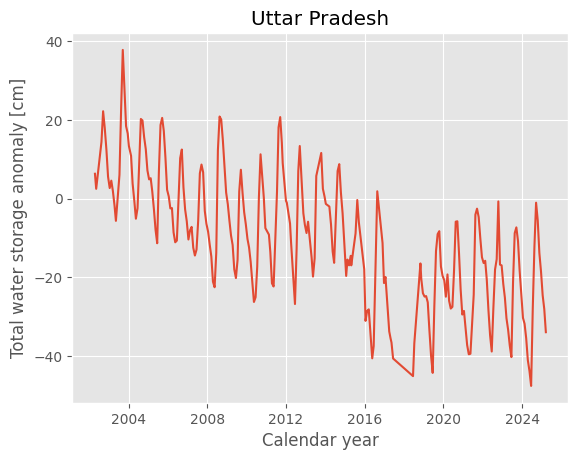

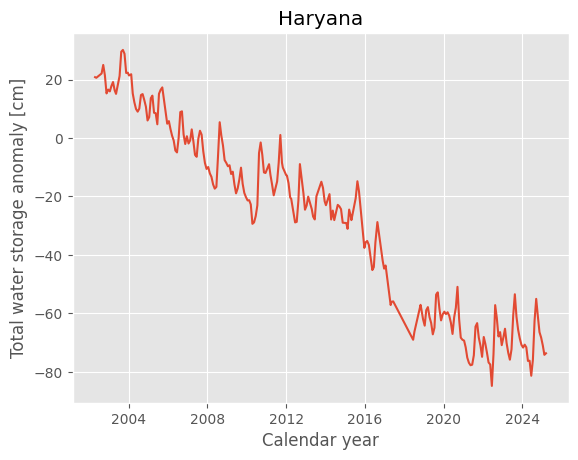

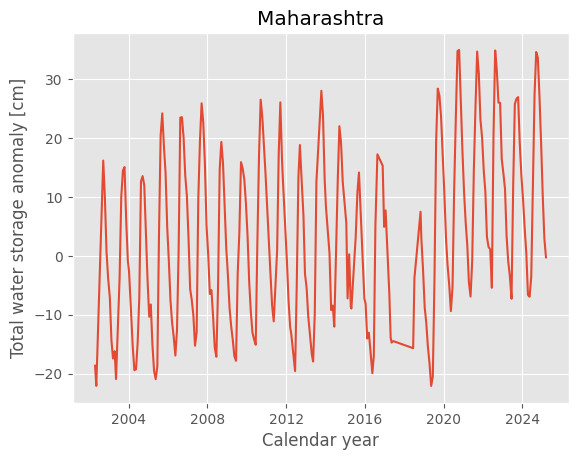

In [18]:
state_names = ['Uttar Pradesh','Haryana','Maharashtra']

for state_name in state_names:
    one_state = basin_shapefile[basin_shapefile['name'] == state_name]
    gdf= one_state

    # Area Weighted Avg Weight File
    weightmap_jpl = xa.pixel_overlaps(ds_jpl,gdf)
    
    # Aggregated to Shapefile
    aggregated_jpl = xa.aggregate(ds_jpl,weightmap_jpl)
    
    # Example as an xarray dataset
    ds_out_jpl = aggregated_jpl.to_dataset()

    plt.figure()
    plt.title(state_name)
    plt.plot(ds_out_jpl.time,ds_out_jpl['lwe_thickness'][0,:])
    plt.xlabel('Calendar year')
    plt.ylabel('Total water storage anomaly [cm]')
    # Save as PDF
    plt.savefig(f"{state_name}.pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"{state_name}.png", dpi=300, bbox_inches='tight')